In [30]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima


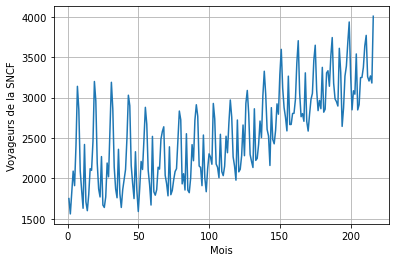

In [22]:
SNCF = pd.read_csv("/home/ibotcazou/Téléchargements/SNCF.csv", sep=";")

# Les données représentent le nombre de passagers mensuels de la SNCF sur 18 ans

plt.plot(np.array(SNCF.Mois), np.array(SNCF.Voy))
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF")
plt.grid()

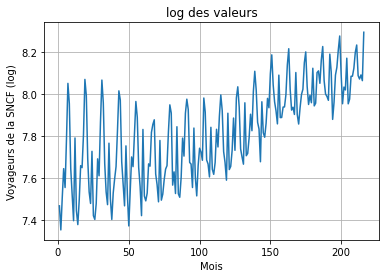

In [23]:
SNCF["LVoy"] = np.log(SNCF["Voy"])
plt.plot(SNCF["Mois"].values, SNCF["LVoy"].values)
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF (log)")
plt.title("log des valeurs")
plt.grid()

57


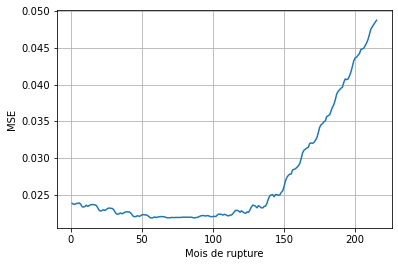

In [28]:
# On fait des régressions sur deux tronçons : [0, R-1] et [R, n-1]
# - Constante sur [0, R-1]
# - Linéaire sur [R, n-1]
n = len(SNCF["LVoy"]) #R pour rupture
MSE = np.zeros(n-1)
LR1, LR2 = LinearRegression(), LinearRegression()

for R in range(1, n):
    X1, X2 = np.array(SNCF["LVoy"][:R]).reshape(-1, 1), np.array(SNCF["LVoy"][R:]).reshape(-1, 1)  #pour avoir une colonne
    Tps1, Tps2 = np.arange(R).reshape(-1, 1), np.arange(R, n).reshape(-1, 1)
    LR1.fit(np.ones(len(X1)).reshape(-1, 1), X1) #Regression contante sur X1, et que des 1 indique que l'on veut une régression constante
    LR2.fit(Tps2, X2) #regression sur la partie de droite sur X2
    PredX1, PredX2 = LR1.predict(Tps1), LR2.predict(Tps2)
    MSE[R-1] = (R*mean_squared_error(X1, PredX1) + (n-R)*mean_squared_error(X2, PredX2))/n #But est de minimiser avec un rapport sur le mombre de données associées
    
plt.plot(range(1, n), MSE)
plt.xlabel("Mois de rupture")
plt.ylabel("MSE")
plt.grid()

R = np.argmin(MSE)+1
# La rupture est détectée en R = 57
print(R)

[[0.]] [7.65999428]
[[0.00350361]] [7.39814416]


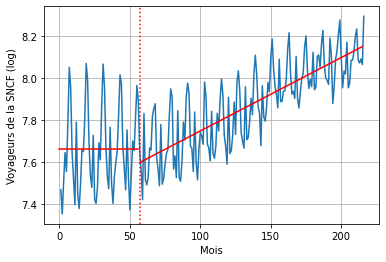

In [29]:
# Graphiques illustrant la rupture avec les deux régressions linéaires 
X1, X2 = np.array(SNCF["LVoy"][:R]).reshape(-1, 1), np.array(SNCF["LVoy"][R:]).reshape(-1, 1)
Tps1, Tps2 = np.arange(R).reshape(-1, 1), np.arange(R, n).reshape(-1, 1)
LR1, LR2 = LinearRegression(), LinearRegression()
LR1.fit(np.ones(len(X1)).reshape(-1, 1), X1)
LR2.fit(Tps2, X2)
PredX1, PredX2 = LR1.predict(Tps1), LR2.predict(Tps2)
plt.plot(SNCF["Mois"].values, SNCF["LVoy"].values)
plt.plot(Tps1, PredX1, color="red")
plt.plot(Tps2, PredX2, color="red")
plt.axvline(R, color="red", linestyle="dotted") #permets de mettre une ligne verticale 
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF (log)")
plt.grid()
print(LR1.coef_,LR1.intercept_)
print(LR2.coef_,LR2.intercept_)


AIC (Akaike Information Criterion) 

$$AIC=2k−2ln(L)$$

où :

    k est le nombre de paramètres estimés dans le modèle.
    ln(L) est le logarithme naturel de la vraisemblance maximale du modèle.

BIC (Bayesian Information Criterion)

La formule du BIC est similaire mais avec une pénalité plus forte pour la complexité du modèle :

$$BIC=ln⁡(n)k−2ln⁡(L)$$

où :

    n est le nombre d'observations.
    k et ln(L) sont les mêmes que pour l'AIC.

In [31]:
X = X2
n = len(X)

# Avec (I-B^12) #Par défault il diminue l'AIC
auto_arima(X, start_p=0, start_q=0, seasonal=True, start_P=0, start_Q=0, m=12, d=0, D=1,
                 with_intercept=True, stepwise=True, trace=True) #force D=1 # trace=True pour afficher # stepwise=True passe d'un modèle à l'autre 
# SARIMA(1,0,1)(0,1,2)[12] avec intercept 


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-414.832, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-451.228, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-450.597, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-367.023, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-419.512, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-451.538, Time=2.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-450.671, Time=3.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-452.429, Time=1.84 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-453.424, Time=1.00 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-452.140, Time=2.91 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-450.736, Time=6.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-441.869, Time=0.53 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-452.688, Time=2.60 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-455.750, Time=2.97 sec
 ARIMA(1,0,1)(0,1,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True)

In [32]:

# Avec (I-B)(I-B^12)
auto_arima(X, start_p=0, start_q=0, seasonal=True, start_P=0, start_Q=0, m=12, d=1, D=1,
                 with_intercept=True, stepwise=True, trace=True) #m est la période 
# SARIMA(0,1,1)(0,1,2)[12] sans intercept


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-345.724, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=-412.988, Time=1.28 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-448.598, Time=1.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-347.706, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=-407.898, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=-450.832, Time=1.92 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-447.470, Time=1.34 sec
 ARIMA(0,1,1)(2,1,1)[12] intercept   : AIC=-448.357, Time=4.28 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=-448.325, Time=4.12 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=-451.013, Time=3.36 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=-390.371, Time=1.29 sec
 ARIMA(1,1,1)(0,1,2)[12] intercept   : AIC=-450.326, Time=4.87 sec
 ARIMA(0,1,2)(0,1,2)[12] intercept   : AIC=-450.079, Time=3.76 sec
 ARIMA(1,1,0)(0,1,2)[12] intercept   : AIC=-416.953, Time=1.99 sec
 ARIMA(1,1,2)(0,1,2

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07838D+00    |proj g|=  9.95178D-01

At iterate    5    f= -1.08218D+00    |proj g|=  8.43229D-01

At iterate   10    f= -1.14884D+00    |proj g|=  3.26547D+00

At iterate   15    f= -1.15692D+00    |proj g|=  2.19219D-02

At iterate   20    f= -1.15743D+00    |proj g|=  8.90744D-02

At iterate   25    f= -1.16061D+00    |proj g|=  1.23722D+00

At iterate   30    f= -1.16216D+00    |proj g|=  6.02026D-02

At iterate   35    f= -1.16392D+00    |proj g|=  6.45696D-01

At iterate   40    f= -1.16869D+00    |proj g|=  5.32056D-01

At iterate   45    f= -1.16881D+00    |proj g|=  1.74868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of

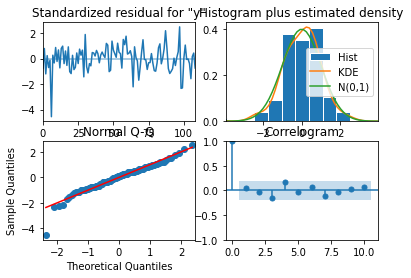

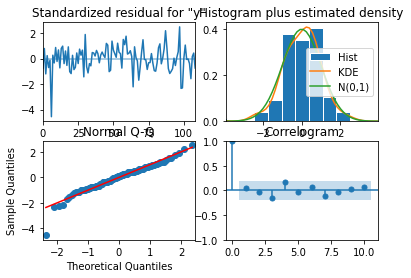

In [37]:

XT = X[:(n-12)] #partie tronquée

Mod01 = SARIMAX(XT, order=(1, 0, 1), seasonal_order=(0, 1, 2, 12), trend='c', enforce_stationarity=False, enforce_invertibility=False)
Mod01F = Mod01.fit()
print(Mod01F.summary())
Mod01F.plot_diagnostics()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05104D+00    |proj g|=  3.75403D-01

At iterate    5    f= -1.14171D+00    |proj g|=  1.08626D+00

At iterate   10    f= -1.14390D+00    |proj g|=  2.38337D-02

At iterate   15    f= -1.14456D+00    |proj g|=  2.53584D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.475D-04  -1.145D+00
  F =  -1.1445551083183712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

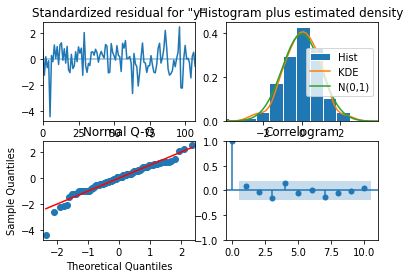

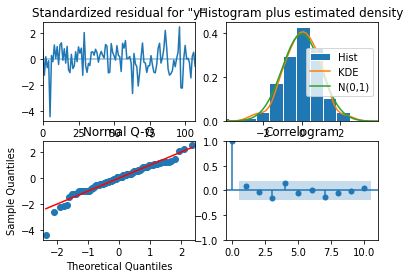

In [38]:
Mod11 = SARIMAX(XT, order=(0, 1, 1), seasonal_order=(0, 1, 2, 12), enforce_stationarity=False, enforce_invertibility=False)
Mod11F = Mod11.fit()
print(Mod11F.summary())
Mod11F.plot_diagnostics()

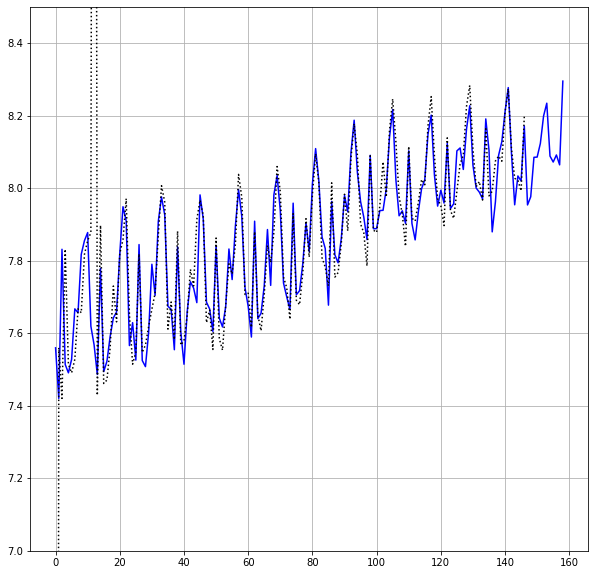

In [42]:
# Dans les deux cas : Q=2 est remis en question
plt.figure(figsize=(10,10))
plt.plot(X, color="blue")
plt.ylim([7, 8.5])
#plt.plot(Mod01F.fittedvalues, color="r", linestyle="dotted")
plt.plot(Mod11F.fittedvalues, color="black", linestyle="dotted")
plt.grid()

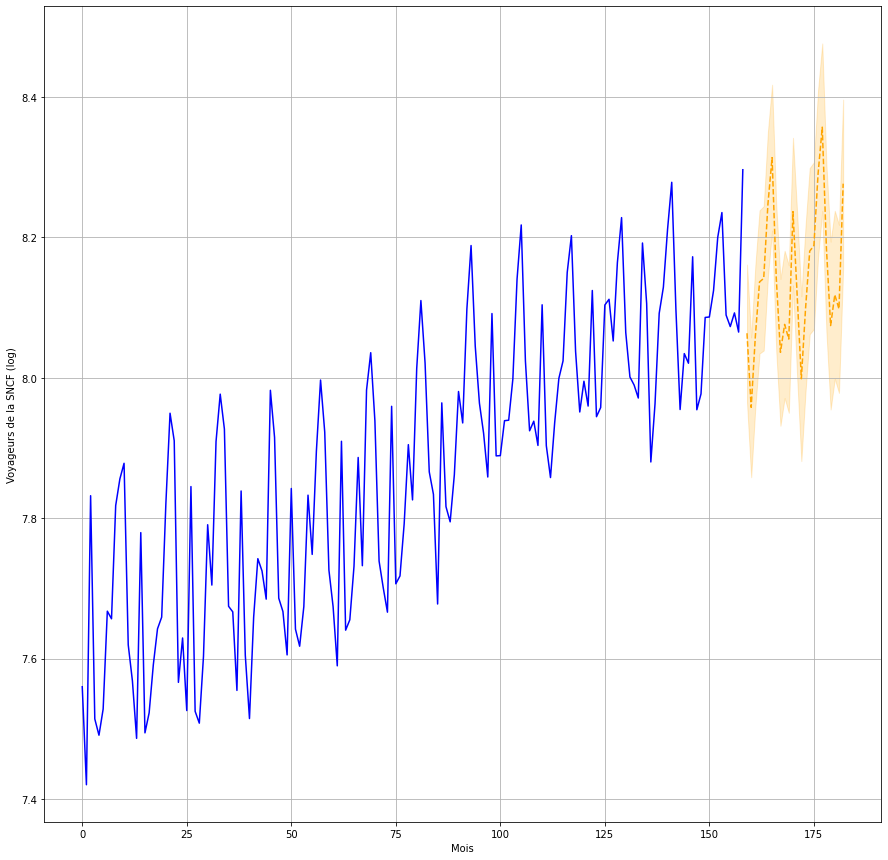

In [47]:
Pred01 = Mod01F.get_forecast(steps=24).summary_frame(alpha=0.05)
plt.figure(figsize=(15,15))
plt.plot(X, color="blue")
plt.plot(range(n, n+24), Pred01['mean'].values, linestyle='--', color="orange")#ne relie pas les deux courbe 
plt.fill_between(range(n, n+24), Pred01['mean_ci_lower'], Pred01['mean_ci_upper'], color='orange', alpha=0.2) #colorier entre les deux 
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF (log)")
plt.grid()

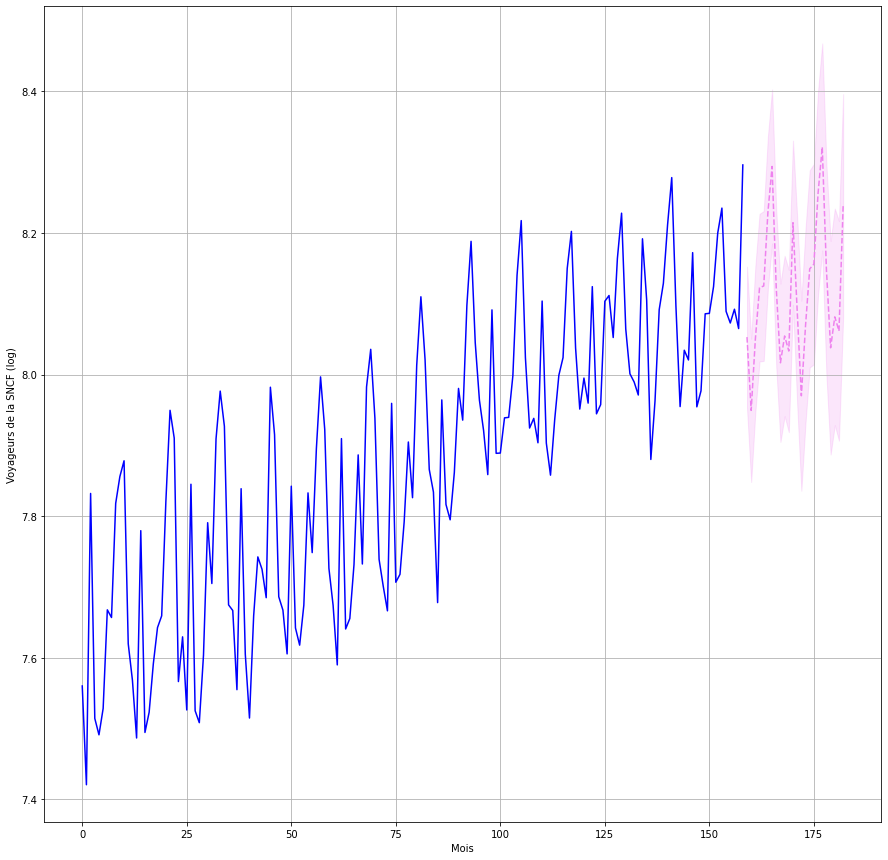

In [49]:
Pred11 = Mod11F.get_forecast(steps=24).summary_frame(alpha=0.05)
plt.figure(figsize=(15,15))
plt.plot(X, color="blue")
plt.plot(range(n, n+24), Pred11['mean'].values, linestyle='--', color="violet")
plt.fill_between(range(n, n+24), Pred11['mean_ci_lower'], Pred11['mean_ci_upper'], color='violet', alpha=0.2)
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF (log)")
plt.grid()


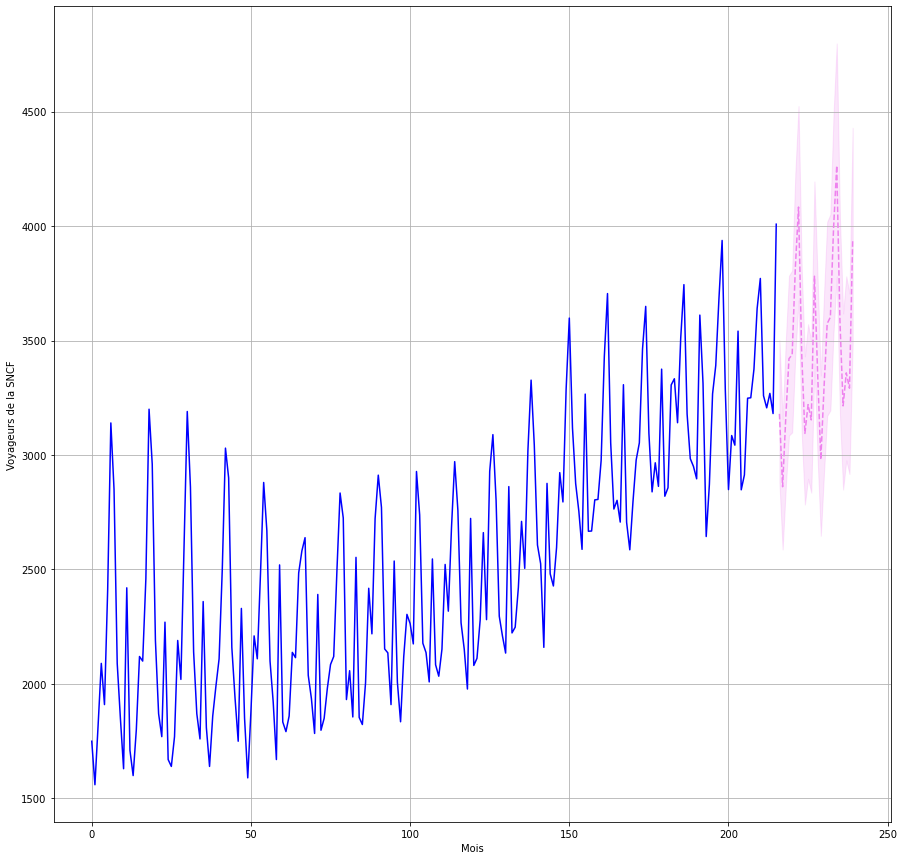

In [52]:

# Exemple de prédiction avec Mod01
plt.figure(figsize=(15,15))
plt.plot(SNCF["Voy"].values, color="blue")
n = len(SNCF["Voy"])
plt.plot(range(n, n+24), np.exp(Pred01['mean'].values + Mod01F.params[5]/2), linestyle='--', color="violet") #Mod01F.params[5] correspond à la variance
plt.fill_between(range(n, n+24), np.exp(Pred01['mean_ci_lower']), np.exp(Pred01['mean_ci_upper']), color='violet', alpha=0.2)
plt.xlabel("Mois")
plt.ylabel("Voyageurs de la SNCF")
plt.grid()